In [1]:
import os
import gc

os.chdir('../../')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier
from sklearn.metrics import log_loss, roc_auc_score, average_precision_score, brier_score_loss, precision_recall_curve
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from global_code.util import reduce_mem_usage
import matplotlib.pyplot as plt
import seaborn as sns
from global_code.util import reduce_mem_usage, clf_metric_report, compute_and_plot_permutation_importance, plot_pr_calib_curve, plot_dis_probs, plot_shap_values
import optuna
import arfs.feature_selection.allrelevant as arfsgroot
import shap
import json
import joblib
from venn_abers import VennAbersCalibrator

sns.set(style='whitegrid')

/Users/marcus.silva/Code/modern-ml/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Read train, validation and calibration data

In [4]:
train_df = pd.read_parquet('./week_1/data/processed/train_df.parquet')
validation_df = pd.read_parquet('./week_1/data/processed/validation_df.parquet')
calibration_df = pd.read_parquet('./week_1/data/processed/calibration_df.parquet')

In [5]:
cat_features = ['country', 'broad_job_category']
train_df[cat_features].dtypes

country               category
broad_job_category    category
dtype: object

### Train, Validation, Test Split

In [6]:
target = 'churn_420'

# Input variables and Target dataframes
X_train, y_train = train_df.drop(target, axis=1), train_df.loc[:, target]
X_validation, y_validation= validation_df.drop(target, axis=1), validation_df.loc[:, target]
X_calibration, y_calibration= calibration_df.drop(target, axis=1), calibration_df.loc[:, target]

# Freeing memory
train_df = None
calibration_df = None
validation_df = None
gc.collect()

print('Train Shape: ', X_train.shape, y_train.shape)
print('Validation shape: ', X_validation.shape, y_validation.shape)
print('Calibration shape: ', X_calibration.shape, y_calibration.shape)

Train Shape:  (306649, 152) (306649,)
Validation shape:  (283510, 152) (283510,)
Calibration shape:  (70878, 152) (70878,)


In [7]:
selected_features = None
with open('./week_1/model/selected_features_list.json', 'r') as f:
    selected_features = json.load(f)
print(selected_features)

['interest_rate', 'tenure', 'prior_crypto_balance', 'prior_mean_balance', 'prior_sum_days_between', 'prior_std_days_between', 'prior_mean_days_between', 'prior_max_days_between', 'prior_mean_bank_transfer_in', 'prior_mean_bank_transfer_out', 'prior_mean_crypto_out', 'prior_mean_bank_transfer_in_volume', 'prior_mean_crypto_in_volume', 'prior_sum_crypto_in_volume', 'prior_sum_crypto_out_volume', 'prior_10D_std_days_between', 'prior_10D_mean_bank_transfer_out', 'prior_90D_mean_days_between', 'prior_90D_std_days_between', 'prior_90D_min_days_between', 'prior_90D_mean_bank_transfer_out', 'prior_90D_mean_bank_transfer_in_volume', 'prior_90D_mean_crypto_out_volume', 'prior_180D_sum_days_between', 'prior_180D_mean_days_between', 'prior_180D_max_days_between', 'prior_180D_min_days_between', 'prior_180D_mean_balance', 'prior_365D_sum_days_between', 'prior_365D_mean_days_between', 'prior_365D_std_days_between', 'prior_365D_min_days_between', 'prior_365D_mean_crypto_in_volume', 'prior_450D_sum_day

### Manual Tuning
- **Control**: Manual tuning allows for precise control over the hyperparameters, enabling fine-tuning to achieve optimal performance.
- **Speed**: It can be faster than automated methods, especially when the search space is small or well-understood.
- **Experience in tuning**: Experienced practitioners can leverage their knowledge to make informed decisions, potentially leading to better results.
- **Domain knowledge**: Incorporating domain-specific insights can guide the tuning process, improving model performance in specific contexts.

### Perform Optuna Hyperparameter Tuning

In [8]:
best_params = None

In [9]:
from sklearn.model_selection import KFold


def objective(trial):
    params = {
        'iterations': trial.suggest_categorical('iterations', [50, 100, 150, 200, 300, 500, 750, 1000]),
        'max_depth': trial.suggest_categorical('depth', [4, 6, 8, 10, 12, 14]),
        'colsample_bylevel': trial.suggest_categorical('colsample_bylevel', [0.5, 0.7, 0.8, 0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.5, 0.7, 0.8, 1.0]),
        #'eval_metric': 'PRAUC:use_weights=false',
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True),
        #'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 1e-1),
        'auto_class_weights': trial.suggest_categorical('auto_class_weights', ['Balanced', 'SqrtBalanced', None]),
        'cat_features': cat_features,
        'verbose': 0
    }

    model = CatBoostClassifier(**params)
    kf = KFold(n_splits=3, shuffle=True, random_state=55)
    avg_precision_scores = []

    for train_index, val_index in kf.split(X_train[selected_features]):
        X_train_fold, X_val_fold = X_train[selected_features].iloc[train_index], X_train[selected_features].iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        #model.fit(X_train_fold, y_train_fold, eval_set=(X_val_fold, y_val_fold), early_stopping_rounds=200)
        model.fit(X_train_fold, y_train_fold, early_stopping_rounds=200)
        y_pred_fold = model.predict_proba(X_val_fold)[:, 1]
        avg_precision_scores.append(average_precision_score(y_val_fold, y_pred_fold))

    return np.mean(avg_precision_scores)

study = optuna.create_study(direction='maximize')

# Optimize for 1 hour 
# print('Tuning the model...')
#study.optimize(objective, timeout=3600)

# Optimize for 1 minute
print('Tuning the model...')
study.optimize(objective, timeout=60, n_trials=2)

best_params = study.best_params
print(f'Best parameters: {best_params}')

[I 2025-01-12 20:06:07,406] A new study created in memory with name: no-name-d1fc1995-6b81-4fa9-8027-6770fcd3872c


Tuning the model...


[I 2025-01-12 20:06:53,430] Trial 0 finished with value: 0.017025690297133154 and parameters: {'iterations': 500, 'depth': 6, 'colsample_bylevel': 0.8, 'subsample': 0.5, 'learning_rate': 0.0006126371858510798, 'auto_class_weights': 'Balanced'}. Best is trial 0 with value: 0.017025690297133154.
[I 2025-01-12 20:07:21,084] Trial 1 finished with value: 0.016751952560649822 and parameters: {'iterations': 200, 'depth': 8, 'colsample_bylevel': 0.7, 'subsample': 1.0, 'learning_rate': 0.003492626334110504, 'auto_class_weights': None}. Best is trial 0 with value: 0.017025690297133154.


Best parameters: {'iterations': 500, 'depth': 6, 'colsample_bylevel': 0.8, 'subsample': 0.5, 'learning_rate': 0.0006126371858510798, 'auto_class_weights': 'Balanced'}


In [10]:
# Save the best parameters to a JSON file
print('Saving the best parameters to a JSON file...\n ', json.dumps(best_params, indent=4))
best_params_path = './week_1/model/best_params.json'
with open(best_params_path, 'w') as f:
    json.dump(best_params, f, indent=4)

Saving the best parameters to a JSON file...
  {
    "iterations": 500,
    "depth": 6,
    "colsample_bylevel": 0.8,
    "subsample": 0.5,
    "learning_rate": 0.0006126371858510798,
    "auto_class_weights": "Balanced"
}


### Retrain the Model with the Best Parameters

In [44]:
best_params = None
if not best_params: 
    best_params = {'iterations': 750, 'depth': 8, 'colsample_bylevel': 0.8, 'subsample': 0.4, 'learning_rate': 0.003, 'auto_class_weights': 'SqrtBalanced'}
    #best_params = {'iterations': 750, 'depth': 8, 'colsample_bylevel': 0.8, 'subsample': 0.5, 'learning_rate': 0.01, 'auto_class_weights': 'SqrtBalanced'}

#model_tunned = CatBoostClassifier(**best_params, eval_metric='PRAUC:use_weights=false', cat_features=cat_features, early_stopping_rounds=200, random_state=55)
model_tunned = CatBoostClassifier(**best_params, eval_metric='PRAUC:use_weights=false', cat_features=cat_features, random_state=55)
model_tunned.fit(X_train[selected_features], y_train, eval_set=(X_validation[selected_features], y_validation))

y_pred_tunned = model_tunned.predict_proba(X_validation[selected_features])[:, 1]

0:	learn: 0.0181754	test: 0.0234413	best: 0.0234413 (0)	total: 91ms	remaining: 1m 8s
1:	learn: 0.0182976	test: 0.0280926	best: 0.0280926 (1)	total: 182ms	remaining: 1m 8s
2:	learn: 0.0179073	test: 0.0286140	best: 0.0286140 (2)	total: 269ms	remaining: 1m 6s
3:	learn: 0.0178585	test: 0.0287918	best: 0.0287918 (3)	total: 352ms	remaining: 1m 5s
4:	learn: 0.0184784	test: 0.0287859	best: 0.0287918 (3)	total: 438ms	remaining: 1m 5s
5:	learn: 0.0181304	test: 0.0290534	best: 0.0290534 (5)	total: 523ms	remaining: 1m 4s
6:	learn: 0.0185146	test: 0.0291088	best: 0.0291088 (6)	total: 610ms	remaining: 1m 4s
7:	learn: 0.0190126	test: 0.0292676	best: 0.0292676 (7)	total: 721ms	remaining: 1m 6s
8:	learn: 0.0192187	test: 0.0292845	best: 0.0292845 (8)	total: 819ms	remaining: 1m 7s
9:	learn: 0.0193489	test: 0.0291442	best: 0.0292845 (8)	total: 911ms	remaining: 1m 7s
10:	learn: 0.0193777	test: 0.0295754	best: 0.0295754 (10)	total: 1.01s	remaining: 1m 7s
11:	learn: 0.0197558	test: 0.0293071	best: 0.0295754 

In [45]:
# Model metrics report
clf_metric_report(y_pred_tunned, y_validation)

Evaluating the model...
ROC AUC: 0.6887885317809944
Brier Score: 0.18035795402906535
Average Precision: 0.030131135261490048
Log Loss: 0.5523835700098298


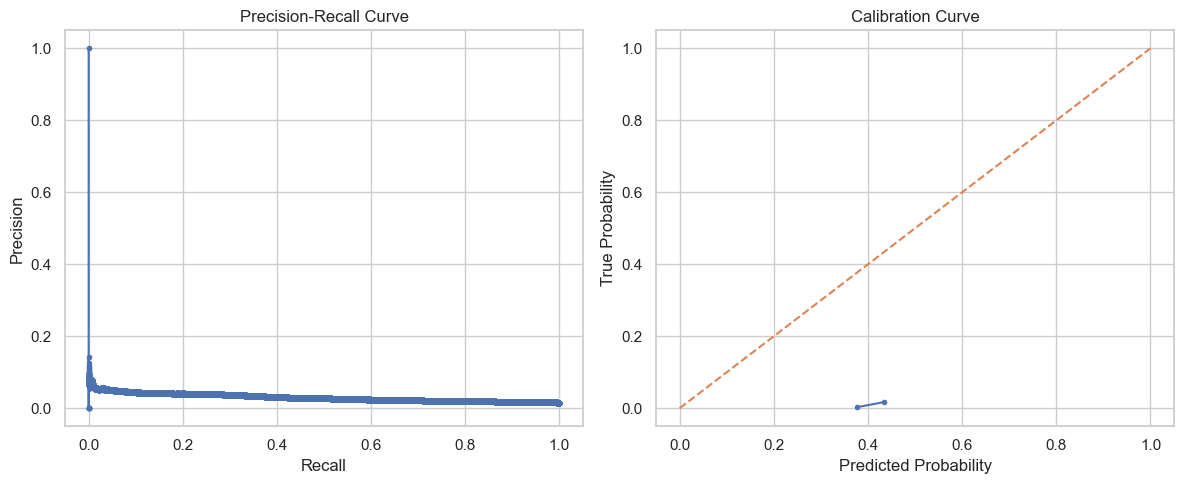

In [46]:
# PR Curve and Calibration curve
plot_pr_calib_curve(y_pred_tunned, y_validation)

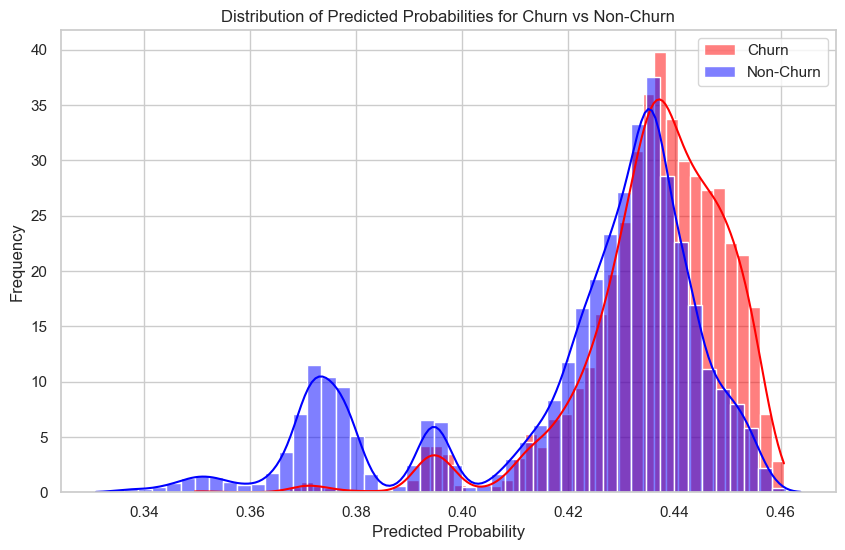

In [47]:
# Distribution of predicted probabilities
plot_dis_probs(y_pred_tunned, y_validation)

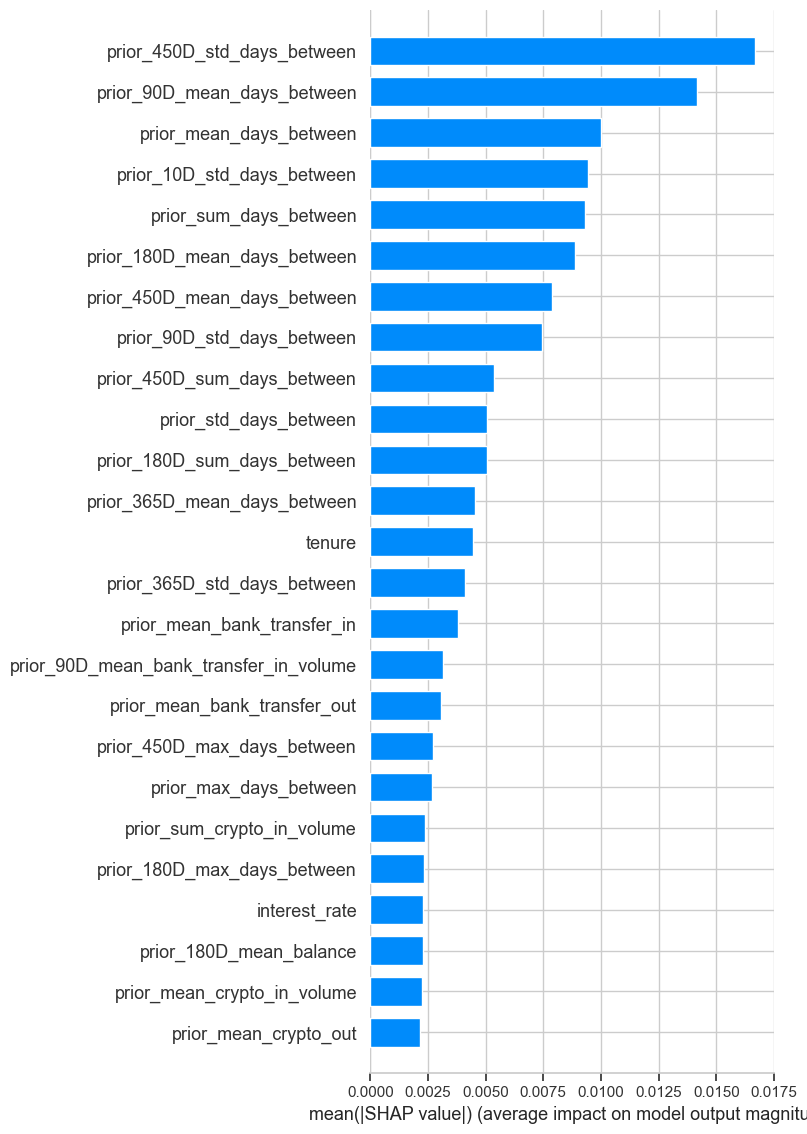

In [48]:
# SHAP Values
shape_explainer = shap.Explainer(model_tunned)
shape_values = shape_explainer(X_validation[selected_features])
plot_shap_values(shape_values, X_validation[selected_features], y_validation)

# Comparing the models

In [49]:
# Load the baseline and feature selection models
baseline_model_path = './week_1/model/baseline_model.joblib'
feat_selection_model_path = './week_1/model/feat_selection_model.joblib'

baseline_model = joblib.load(baseline_model_path)
feat_selection_model = joblib.load(feat_selection_model_path)

# Predict using the baseline model
y_pred_baseline = baseline_model.predict_proba(X_validation)[:, 1]

# Predict using the feature selection model
y_pred_feat_selection = feat_selection_model.predict_proba(X_validation[selected_features])[:, 1]

# Compare the models using clf_metric_report
print("Baseline Model Metrics:")
clf_metric_report(y_pred_baseline, y_validation)

print("\nFeature Selection Model Metrics:")
clf_metric_report(y_pred_feat_selection, y_validation)

print("\nTuned Model Metrics:")
clf_metric_report(y_pred_tunned, y_validation)

Baseline Model Metrics:
Evaluating the model...
ROC AUC: 0.6874491984817513
Brier Score: 0.27357068114462263
Average Precision: 0.02813379957569347
Log Loss: 0.7299075239299322

Feature Selection Model Metrics:
Evaluating the model...
ROC AUC: 0.6932547527225034
Brier Score: 0.2562781920929616
Average Precision: 0.02992709580252091
Log Loss: 0.7023102442145577

Tuned Model Metrics:
Evaluating the model...
ROC AUC: 0.6887885317809944
Brier Score: 0.18035795402906535
Average Precision: 0.030131135261490048
Log Loss: 0.5523835700098298


In [50]:
# Save the model trained with selected features
tunned_model_path = './week_1/model/tunned_model.joblib'
joblib.dump(model_tunned, tunned_model_path)

print(f"Baseline model saved to: {tunned_model_path}")

Baseline model saved to: ./week_1/model/tunned_model.joblib
